In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.compose import ColumnwiseTransformer
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.base import BaseTransformer

from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.transformations.compose import FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures

from catboost import CatBoostRegressor
import shap as sp

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

In [3]:
dates = pd.read_csv('m5/calendar.csv').reset_index()
dates['index'] = 'd_' + (dates['index'].astype(int)+1).astype(str)
dates =  dates.set_index('index')['date'].to_frame('ds')

In [4]:
df = pd.read_csv('m5/sales_train_evaluation.csv')

In [5]:
df['MCC'] = df['item_id'] + df['store_id']
df = df.drop(['item_id','dept_id','cat_id','store_id','state_id'], axis=1)

In [6]:
df = df.set_index('MCC')
df['sum'] = df.sum(axis=1)
df = df.sort_values('sum', ascending=False)
df = df.iloc[:5].drop('sum', axis=1).reset_index()
df = pd.melt(df, id_vars=['MCC'], var_name='day', value_name='y').set_index('day')

In [7]:
df = df.merge(dates, left_index=True, right_index=True, how='left').set_index('ds')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [8]:
targets = ['y']
groups = ['MCC'] 
#df = df[df.MCC == MCC[0]].drop('MCC', axis=1)

In [9]:
y_train, y_test = df[df.index < (df.index.max() - pd.DateOffset(months=6))], df[df.index >= (df.index.max() - pd.DateOffset(months=6))] 
index_train, index_test = y_train.index, y_test.index
forecast_index = pd.date_range(index_train.max() + pd.DateOffset(days=1), index_train.max()+ pd.DateOffset(years=1))
groups_list = df.drop_duplicates(groups)[groups]

In [10]:
class ZScoreTransformer(BaseTransformer):
    def __init__(self, window=30):
        self.window = window
        super(ZScoreTransformer, self).__init__()

    def transform(self, Z, X=None):
        z = Z.copy()
        z['mean_30'] = z['y'].rolling(window=self.window).mean()
        z['std_30'] = z['y'].rolling(window=self.window).std()
        z['z_score'] = (z['y'] - z['mean_30']) / z['std_30']
        z.loc[np.abs(z['z_score']) > 3, 'y'] = np.nan
        z.drop(columns=['mean_30', 'std_30', 'z_score'], inplace=True)
        return z

In [11]:
def inverse_transform(pipeline, X_transformed):
    # Iterate over the steps in reverse order
    for name, transformer in reversed(pipeline.steps):
        if hasattr(transformer, 'inverse_transform') & (name not in ['z_score']):
            X_transformed = transformer.inverse_transform(X_transformed)
    return X_transformed

In [12]:
transform = Pipeline(
    steps=[
        #("log", LogTransformer(offset=1)),
        #("z_score", ZScoreTransformer(window=30)),
        ("imputer", Imputer(method="drift")),
        #("scale", TabularToSeriesAdaptor(StandardScaler())),
    ]
)

window_summarizer = WindowSummarizer(
    lag_feature={
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 14], [1,21], [1, 28], [15, 21], [22,28]],
        "std": [[1, 7], [1, 14], [1,21], [1, 28], [15, 21], [22,28]],
    }
)

multi_window_summarizer = ColumnEnsembleTransformer(
    transformers = [(f'window_summarizer_{target}', window_summarizer, target) for target in targets]
)

fourier_featurizer = FourierFeatures(sp_list=[365.25, 7], fourier_terms_list=[10, 2], freq='D')

featurizer = FeatureUnion([multi_window_summarizer, fourier_featurizer])

In [13]:
def apply_transform_pipeline(group):
    return transform.fit_transform(group[['y']])

def apply_featurizer(group):
    return featurizer.fit_transform(group)

In [14]:
y_train_transform = y_train.groupby(groups).apply(apply_transform_pipeline).swaplevel().sort_index()
y_full_transform = y_train_transform.reindex(y_train_transform.index.union(pd.DataFrame(forecast_index, columns = ['ds']).merge(groups_list, how='cross').set_index(['ds'] + groups).index,sort=False)).reset_index(groups).sort_index()
X_full = y_full_transform.groupby(groups).apply(apply_featurizer).reset_index(groups)
y_full_transform = y_full_transform.set_index(groups, append=True).sort_index()

In [15]:
lag_features = [f"ColumnEnsembleTransformer__{j}_lag_{i}" for i in window_summarizer.lag_feature["lag"] for j in targets]
mean_features = [f"ColumnEnsembleTransformer__{j}_mean_{start}_{end}" for start, end in window_summarizer.lag_feature["mean"] for j in targets]
std_features = [f"ColumnEnsembleTransformer__{j}_std_{start}_{end}" for start, end in window_summarizer.lag_feature["std"] for j in targets]
fourier_features = [f"FourierFeatures__{fn}_{per}_{i}" for per, freq in zip(fourier_featurizer.sp_list, fourier_featurizer.fourier_terms_list) for i in range(1, freq + 1) for fn in ("cos", "sin")]

X_full = X_full[groups + lag_features + mean_features + std_features + fourier_features].sort_values(by = ['ds'] + groups)
X_train, X_test = X_full.loc[X_full.index <= index_train.max()], X_full.loc[X_full.index > index_train.max()]

In [16]:
models = {}
for target in targets:
    model = CatBoostRegressor(loss_function="RMSE", has_time=True, cat_features = groups)
    model.fit(X_train, y_train_transform[target], verbose=False)
    models[target] = model

In [17]:
update_features = lag_features+mean_features+std_features
for idx in forecast_index:
    y_tmp = y_full_transform.reset_index(groups).loc[idx-pd.DateOffset(28+1):idx]
    b = y_tmp.groupby(groups).apply(apply_featurizer).reset_index(groups).sort_values(by = ['ds'] + groups).iloc[-len(groups_list):]
    X_test.loc[idx, groups + update_features] = b
    for target in targets:
        y_full_transform.loc[idx, target] = models[target].predict(X_test.loc[idx])
    
#y_pred = inverse_transform(transform, y_full_transform.loc[index_test])

Item ID: FOODS_3_090CA_3
MSE: 2324.154305559357
MAPE: 3.301881441736149e+16


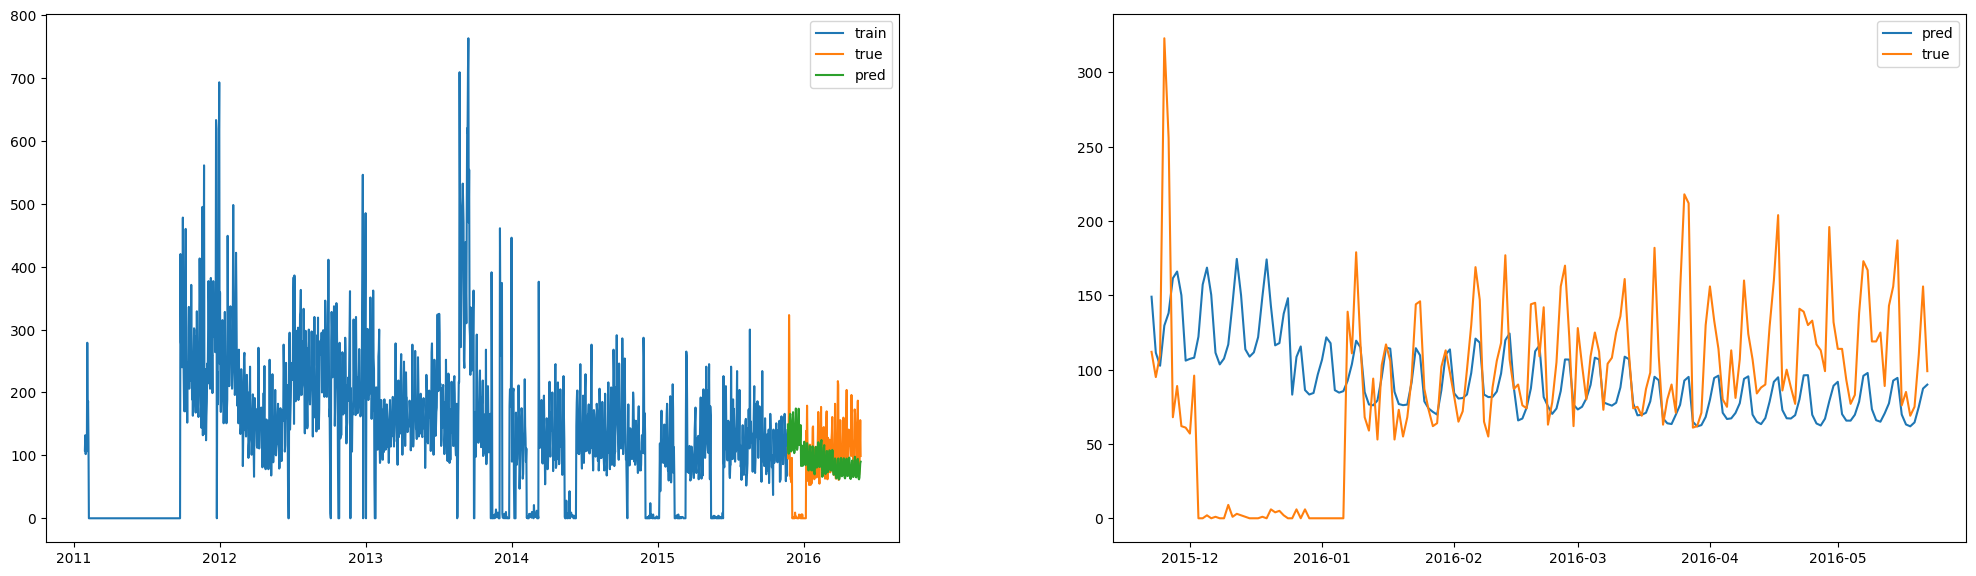

Item ID: FOODS_3_586TX_2
MSE: 2018.2422658507076
MAPE: 3.059330971049124e+16


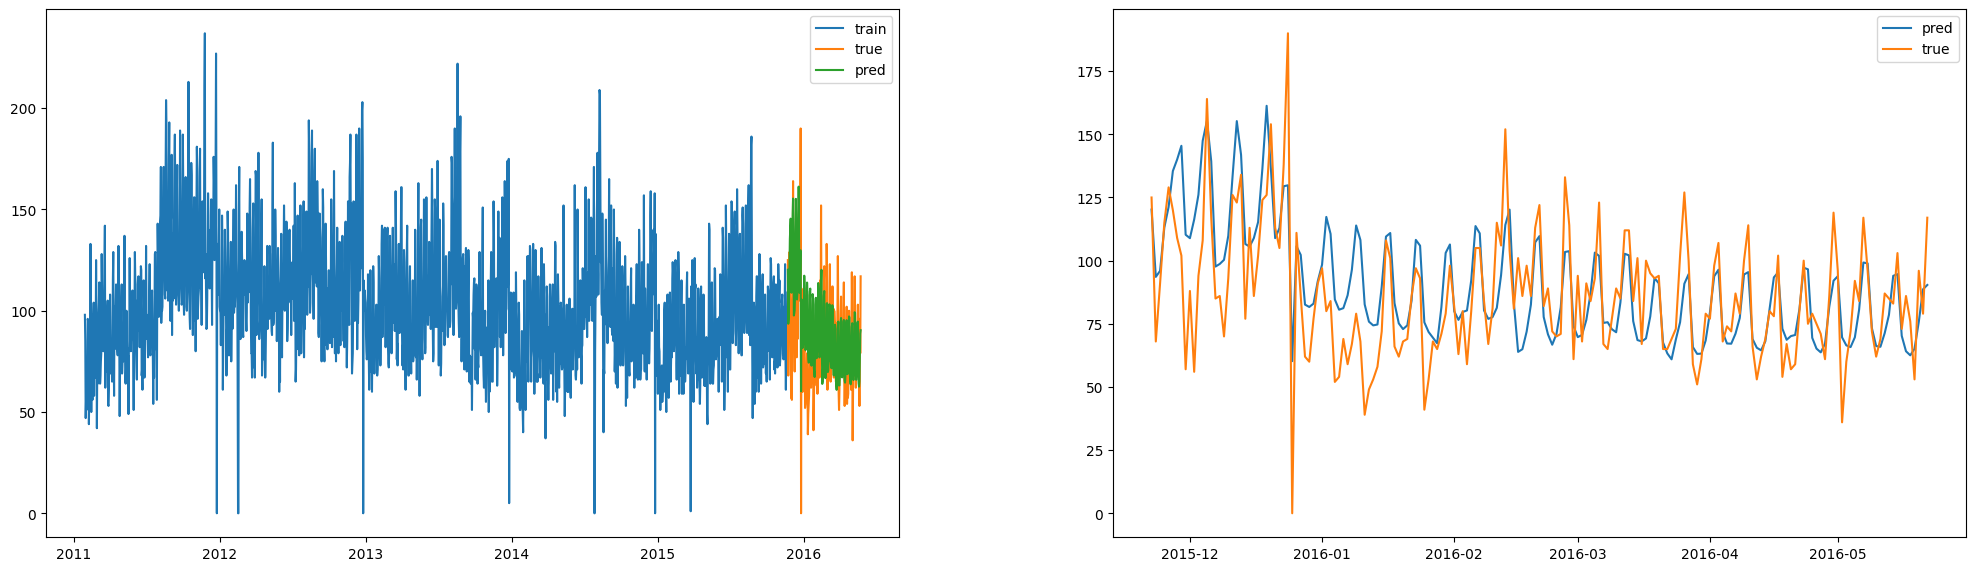

Item ID: FOODS_3_586TX_3
MSE: 1400.359642014902
MAPE: 2.243996407465893e+16


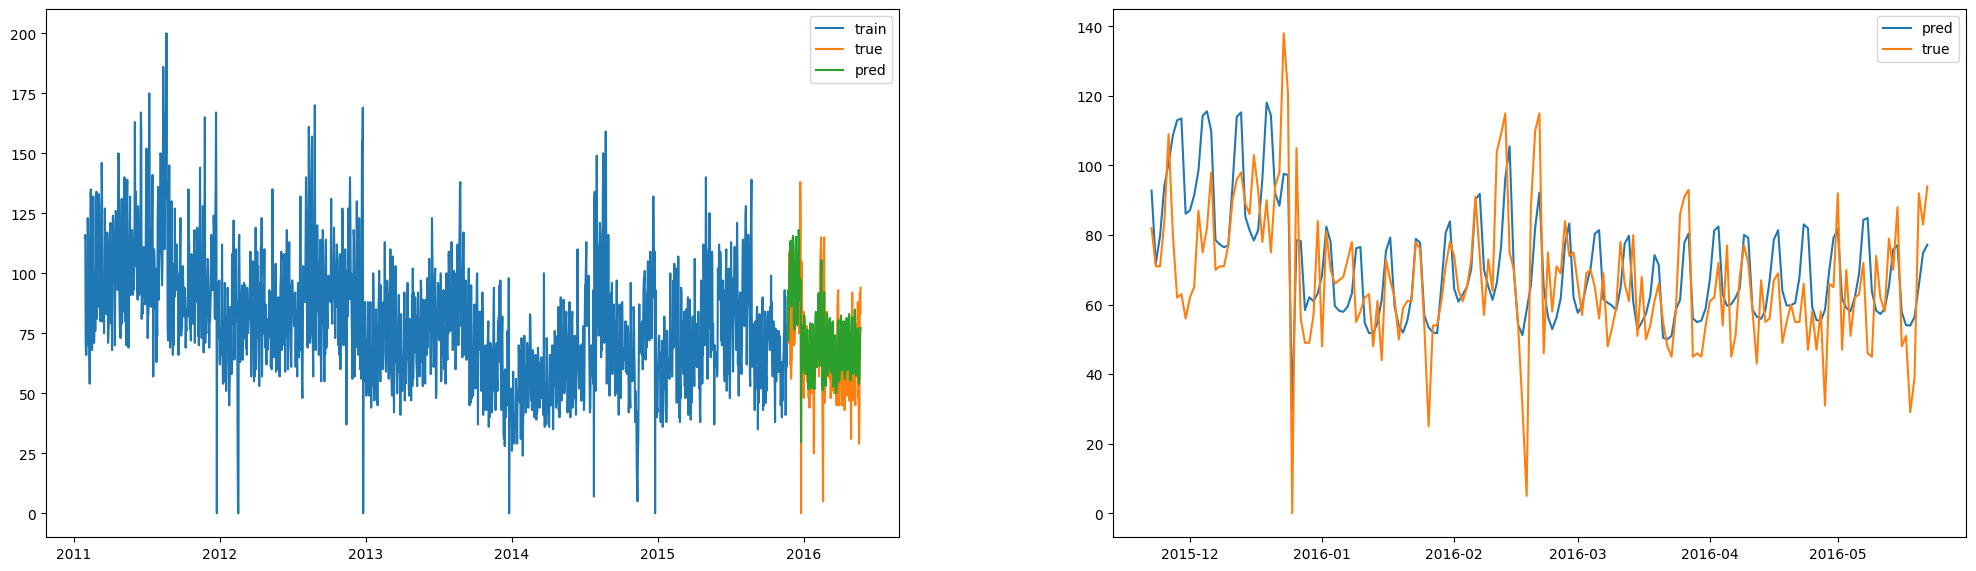

Item ID: FOODS_3_586CA_3
MSE: 1609.5591288683363
MAPE: 2.5819306795490124e+16


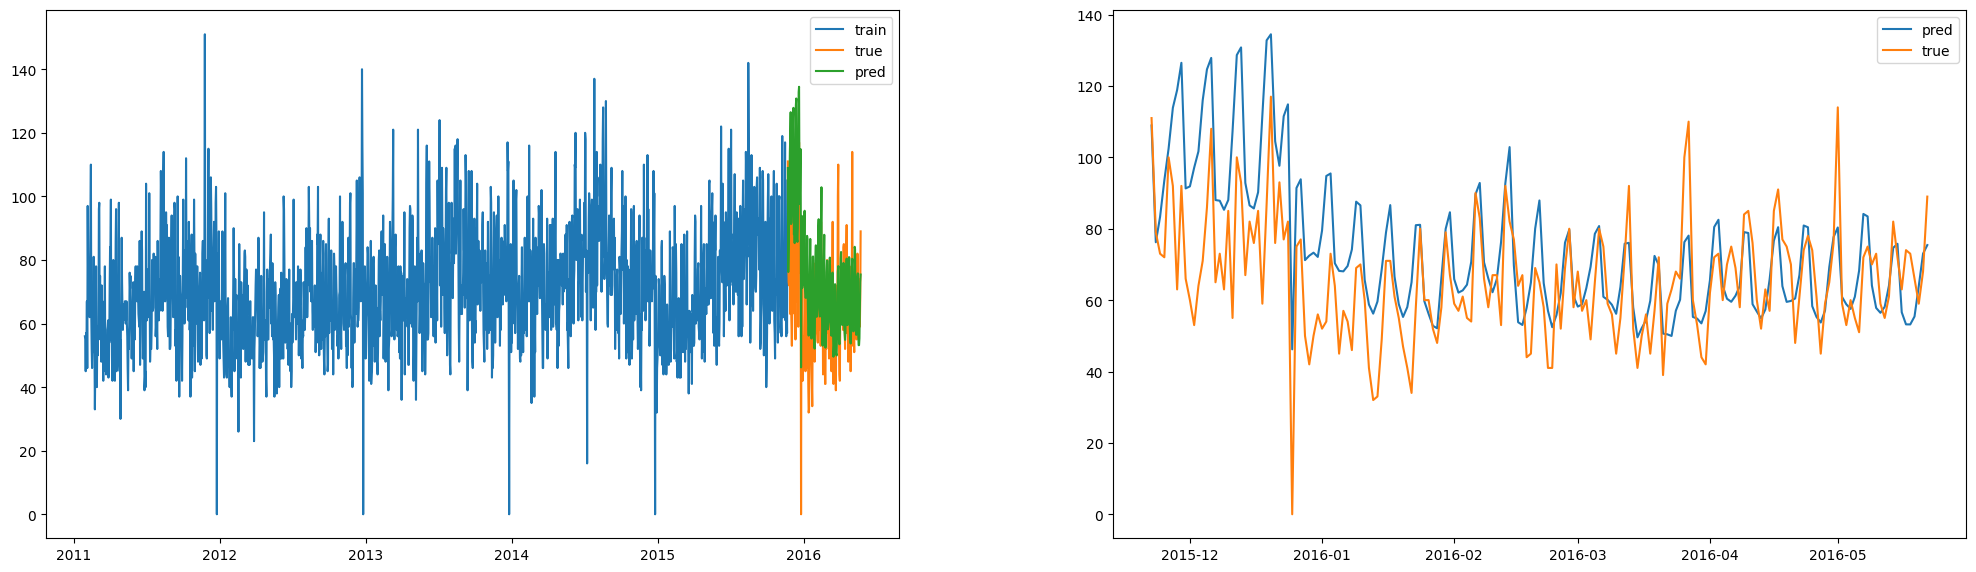

Item ID: FOODS_3_090CA_1
MSE: 1350.5137996776732
MAPE: 2.1364213025722492e+16


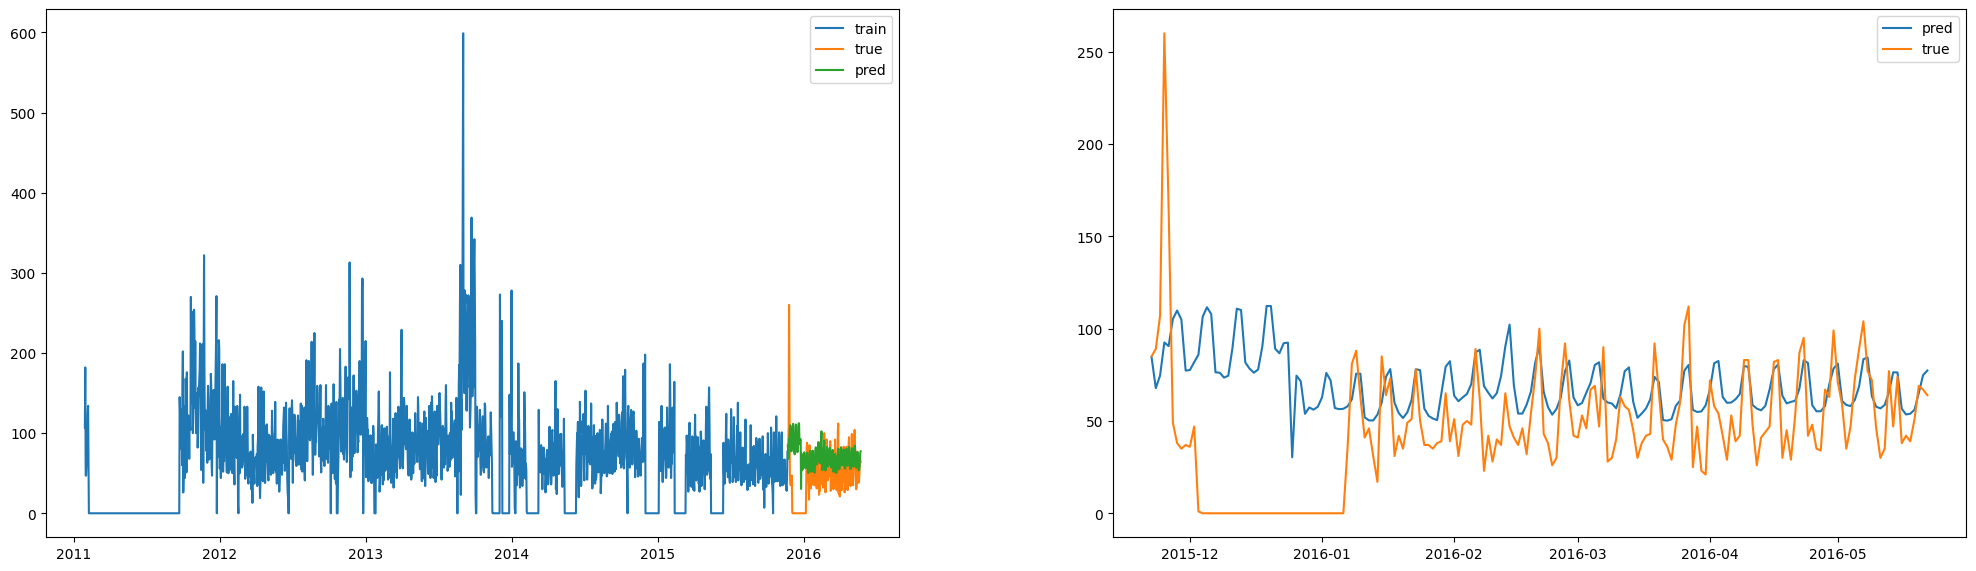

In [70]:
for target in targets:
    for grp in groups_list.values.flatten():
        print("Item ID:", grp)
        
        y_pred_tmp = y_pred.xs(grp, level=1)
        y_train_tmp = y_train.loc[y_train[groups].values==grp]
        y_test_tmp = y_test.loc[y_test[groups].values==grp]
        
        print("MSE:", mean_squared_error(y_test[target], y_pred_tmp[target]))
        print("MAPE:", mean_absolute_percentage_error(y_test[target], y_pred_tmp[target]))

        fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

        ax0.plot(y_train_tmp.index, y_train_tmp[target], label='train')
        ax0.plot(y_test_tmp.index, y_test_tmp[target], label='true')
        ax0.plot(y_pred_tmp.index, y_pred_tmp[target], label='pred')
        ax0.legend()

        ax1.plot(y_pred_tmp.index, y_pred_tmp[target], label='pred')
        ax1.plot(y_test_tmp.index, y_test_tmp[target], label='true')
        ax1.legend()

        plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
        plt.show()

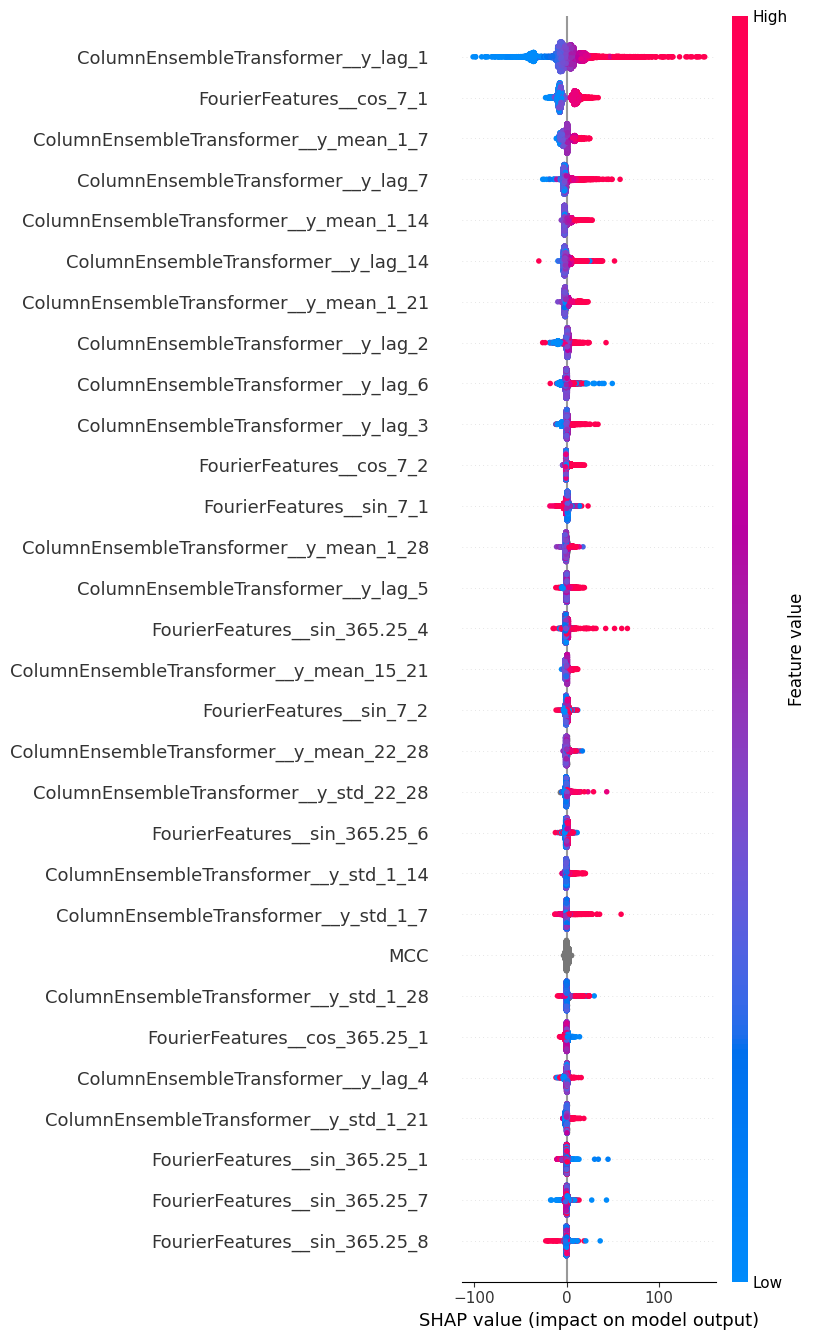

In [19]:
explainer = sp.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train, max_display=30 )